  Preparing metadata (setup.py) ... done
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,777 (46.00 KB)

 Trainable params: 11,777 (46.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/400
27/27 - 1s - 46ms/step - loss: 0.4979 - mae: 0.4761 - mse: 0.4979 - val_loss: 0.1876 - val_mae: 0.2661 - val_mse: 0.1876
Epoch 2/400
27/27 - 0s - 8ms/step - loss: 0.1933 - mae: 0.2782 - mse: 0.1933 - val_loss: 0.1653 - val_mae: 0.2865 - val_mse: 0.1653
Epoch 3/400
27/27 - 0s - 5ms/step - loss: 0.1634 - mae: 0.2490 - mse: 0.1634 - val_loss: 0.1548 - val_mae: 0.2697 - val_mse: 0.1548
Epoch 4/400
27/27 - 0s - 5ms/step - loss: 0.1528 - mae: 0.2425 - mse: 0.1528 - val_loss: 0.1497 - val_mae: 0.2387 - val_mse: 0.1497
Epoch 5/400
27/27 - 0s - 7ms/step - loss: 0.1487 - mae: 0.2368 - mse: 0.1487 - val_loss: 0.1504 - val_mae: 0.2590 - val_mse: 0.1504
Epoch 6/400
27/27 - 0s - 12ms/step - loss: 0.1484 - mae: 0.2414 - mse: 0.1484 - val_loss: 0.1676 - val_mae: 0.2196 - val_mse: 0.1676
Epoch 7/400
27/27 - 0s - 17ms/step - loss: 0.1404 - mae: 0.2231 - mse: 0.1404 - val_loss: 0.1502 - val_mae: 0.2330 - val_mse: 0.1502
Epoch 8/400
27/27 - 0s - 13ms/step - loss: 0.1419 - mae: 0.2427 - mse: 0.

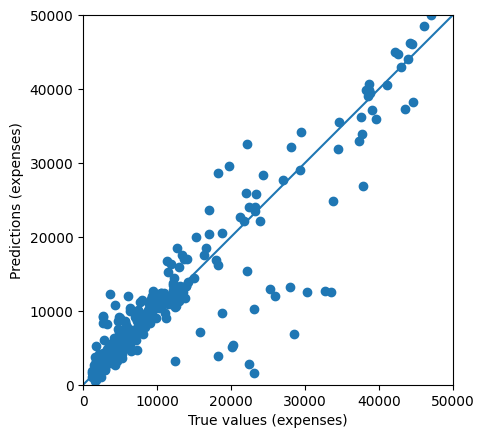

In [5]:
# Install and import libraries
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
    # %tensorflow_version only exists in Colab
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ----------------------------------------------------------------
# 1. Load dataset
# ----------------------------------------------------------------
!wget -q https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')

# ----------------------------------------------------------------
# 2. Encode categorical features
# ----------------------------------------------------------------
dataset['sex'] = dataset['sex'].map({'male': 1, 'female': 0})
dataset['smoker'] = dataset['smoker'].map({'yes': 1, 'no': 0})

# One-hot encode region
dataset = pd.get_dummies(dataset, columns=['region'], drop_first=True)

# Convert boolean dummies to int
for col in ['region_northwest', 'region_southeast', 'region_southwest']:
    dataset[col] = dataset[col].astype(int)

# ----------------------------------------------------------------
# 3. Feature engineering
# ----------------------------------------------------------------
dataset['bmi_smoker'] = dataset['bmi'] * dataset['smoker']
dataset['age_bmi'] = dataset['age'] * dataset['bmi']

# ----------------------------------------------------------------
# 4. Split features and labels
# ----------------------------------------------------------------
X = dataset.drop("expenses", axis=1)
y = dataset["expenses"]

# ----------------------------------------------------------------
# 5. Scale features and labels
# ----------------------------------------------------------------
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# ----------------------------------------------------------------
# 6. Build model
# ----------------------------------------------------------------
def build_model():
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=[X_train.shape[1]]),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)  # regression output
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss='mse',
                  metrics=['mae', 'mse'])
    return model

model = build_model()
model.summary()

# ----------------------------------------------------------------
# 7. Train with EarlyStopping
# ----------------------------------------------------------------
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_mae', patience=25, restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=400,
    batch_size=32,
    verbose=2,
    callbacks=[early_stop]
)

# ----------------------------------------------------------------
# 8. Evaluate
# ----------------------------------------------------------------
loss, mae, mse = model.evaluate(X_test, y_test, verbose=2)

# Correctly unscale MAE
mae_unscaled = mae * scaler_y.scale_[0]


print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae_unscaled))

if mae_unscaled < 3500:
    print("You passed the challenge. Great job!")
else:
    print("The Mean Abs Error must be less than 3500. Keep trying.")

# ----------------------------------------------------------------
# 9. Predictions & Plot
# ----------------------------------------------------------------
test_predictions = model.predict(X_test).flatten()

# Rescale predictions and true values
test_predictions_unscaled = scaler_y.inverse_transform(
    test_predictions.reshape(-1, 1)
).flatten()
y_test_unscaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Scatter plot
a = plt.axes(aspect='equal')
plt.scatter(y_test_unscaled, test_predictions_unscaled)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.show()
